In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca637.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca3400.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca783.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca3927.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca4109.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca95.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca488.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca2140.jp

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

import os
import datetime
import shutil
import itertools
import random
from PIL import Image


import numpy as np
import pandas as pd
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, concatenate, Conv2DTranspose, Dropout, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.models import load_model

from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


modules loaded


In [3]:
base_dir = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'
classes = ['lung_aca', 'lung_n', 'lung_scc']

split_dir = 'split_lung_images'

for split in ['train', 'val', 'test']:
    for cls in classes:
        os.makedirs(os.path.join(split_dir, split, cls), exist_ok=True)

def split_and_copy_images(class_dir, class_name):
    all_images = [img for img in os.listdir(class_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

    train_images, temp_images = train_test_split(all_images, test_size=0.3, random_state=42, shuffle=True)

    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42, shuffle=True)

    def copy_images(images, dest):
        for img in images:
            src_path = os.path.join(class_dir, img)
            dst_path = os.path.join(split_dir, dest, class_name, img)
            shutil.copy(src_path, dst_path)

    copy_images(train_images, 'train')
    copy_images(val_images, 'val')
    copy_images(test_images, 'test')

for cls in classes:
    class_path = os.path.join(base_dir, cls)
    split_and_copy_images(class_path, cls)

print("Images have been split into training, validation, and testing sets.")


Images have been split into training, validation, and testing sets.


Displaying images from: train


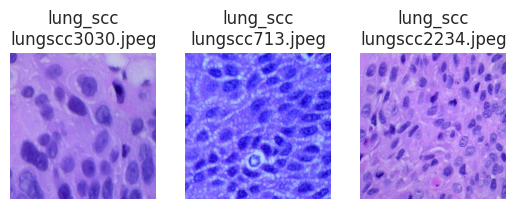

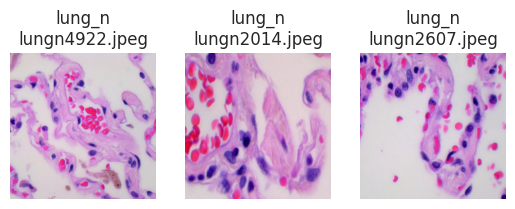

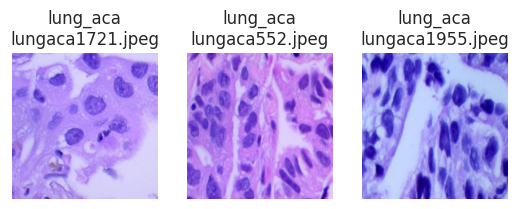

Displaying images from: val


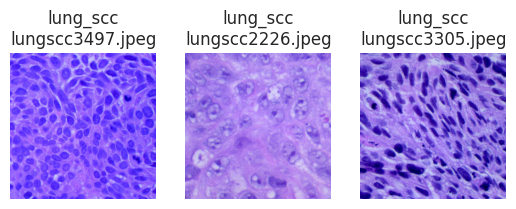

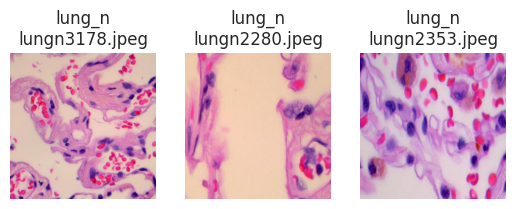

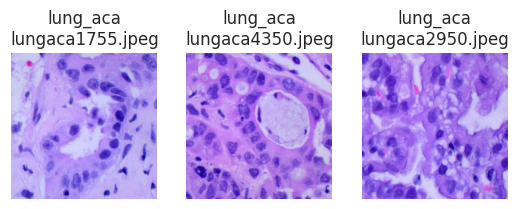

Displaying images from: test


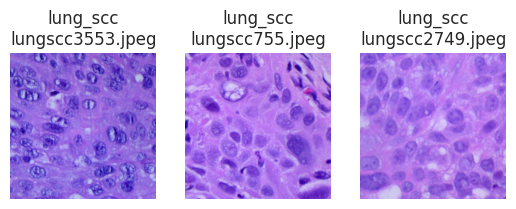

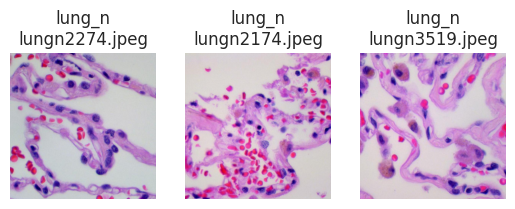

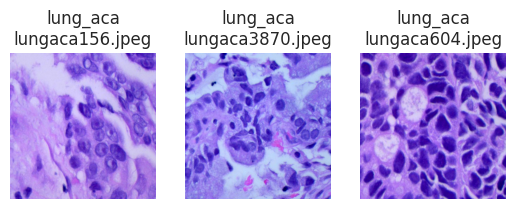

In [4]:
base_dir = 'split_lung_images'

def display_random_images(base_dir, num_images=3):
    for split in ['train', 'val', 'test']:
        print(f"Displaying images from: {split}")
        split_dir = os.path.join(base_dir, split)
        for cls in os.listdir(split_dir):
            class_dir = os.path.join(split_dir, cls)
            image_files = os.listdir(class_dir)
            sample_size = min(num_images, len(image_files))
            random_images = random.sample(image_files, sample_size)
            for i, img_name in enumerate(random_images):
                img_path = os.path.join(class_dir, img_name)
                img = Image.open(img_path)
                plt.subplot(1, sample_size, i+1) 
                plt.imshow(img)
                plt.axis('off')
                plt.title(f'{cls}\n{img_name}')
            plt.show()

display_random_images(base_dir)


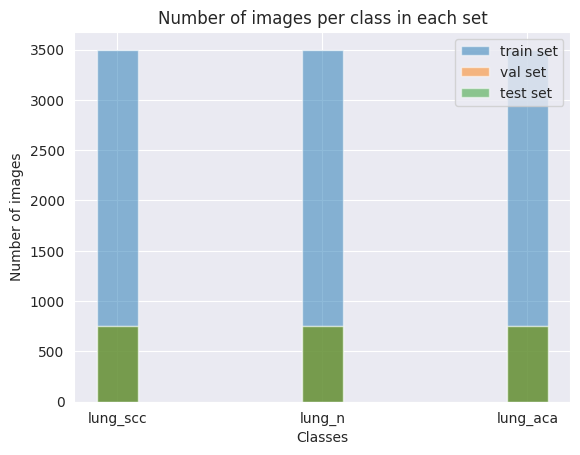

In [5]:
def plot_image_counts(base_dir):
    counts = {}
    for split in ['train', 'val', 'test']:
        counts[split] = {}
        split_dir = os.path.join(base_dir, split)
        for cls in os.listdir(split_dir):
            class_dir = os.path.join(split_dir, cls)
            counts[split][cls] = len(os.listdir(class_dir))

    fig, ax = plt.subplots()
    for i, split in enumerate(['train', 'val', 'test']):
        sub_counts = counts[split]
        ax.bar(range(len(sub_counts)), sub_counts.values(), width=0.2, align='center', alpha=0.5, label=f'{split} set')
        ax.set_xticks(range(len(sub_counts)))
        ax.set_xticklabels(sub_counts.keys())
        ax.set_xlabel('Classes')
        ax.set_ylabel('Number of images')
        ax.set_title('Number of images per class in each set')
        ax.legend()

    plt.show()
    

plot_image_counts(base_dir)

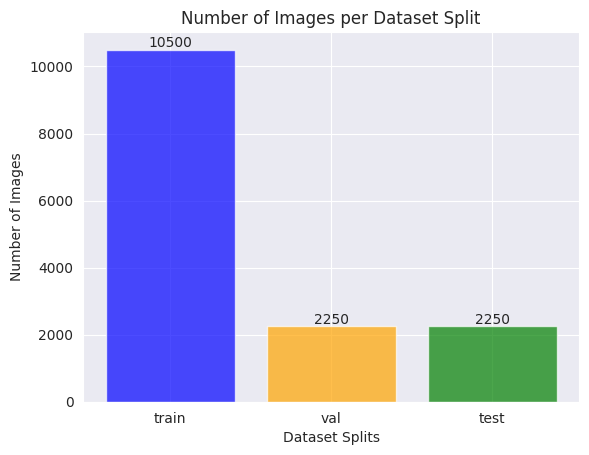

In [7]:
base_dir = 'split_lung_images'

image_counts = {}

splits = ['train', 'val', 'test']

for split in splits:
    split_dir = os.path.join(base_dir, split)
    image_counts[split] = sum([len(files) for r, d, files in os.walk(split_dir)])

bar_locations = range(len(image_counts))

plt.bar(bar_locations, image_counts.values(), align='center', alpha=0.7, color=['blue', 'orange', 'green'])

for i, count in enumerate(image_counts.values()):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.xticks(bar_locations, image_counts.keys())

plt.xlabel('Dataset Splits')
plt.ylabel('Number of Images')
plt.title('Number of Images per Dataset Split')

plt.show()


In [8]:

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')




train_datagen = ImageDataGenerator(
    rescale=1./255  
)


val_test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

valid_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False 


Found 10500 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.


In [23]:


def conv_block(input_tensor, num_filters):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters=num_filters, kernel_size=(3, 3), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters=num_filters, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

def encoder_block(input_tensor, num_filters):
    """Function to add 2 convolutional layers with the parameters passed to it and then perform max pooling"""
    x = conv_block(input_tensor, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, concat_tensor, num_filters):
    """Function to upsample, concatenate and then add 2 convolutional layers"""
    x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    x = concatenate([x, concat_tensor], axis=-1)
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape, n_classes):
    """Function to build a U-Net using the building blocks defined above"""
    inputs = Input(input_shape)

    # encoder
    x1, p1 = encoder_block(inputs, 64)
    x2, p2 = encoder_block(p1, 128)
    x3, p3 = encoder_block(p2, 256)
    x4, p4 = encoder_block(p3, 512)

    # bridge
    b = conv_block(p4, 1024)

    # decoder
    d1 = decoder_block(b, x4, 512)
    d2 = decoder_block(d1, x3, 256)
    d3 = decoder_block(d2, x2, 128)
    d4 = decoder_block(d3, x1, 64)


    # Output
    outputs = Conv2D(n_classes, (1, 1), padding='same')(d4)
    outputs = Flatten()(outputs)
    outputs = Dense(n_classes, activation='softmax')(outputs)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

input_shape = (224, 224, 3)  
n_classes = 3  

model_lung = build_unet(input_shape, n_classes)

model_lung.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
model_lung.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 224, 224, 64)         1792      ['input_3[0][0]']             
                                                                                                  
 batch_normalization_36 (Ba  (None, 224, 224, 64)         256       ['conv2d_38[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_36 (Activation)  (None, 224, 224, 64)         0         ['batch_normalization_36

In [25]:


def create_callbacks(early_stop_patience=5, reduce_lr_patience=2, model_checkpoint_path='model_lung.h5'):
    """
    Creates a list of callbacks for training.

    Parameters:
    - early_stop_patience: Number of epochs with no improvement after which training will be stopped.
    - reduce_lr_patience: Number of epochs with no improvement after which learning rate will be reduced.
    - model_checkpoint_path: Path to save the model file.

    Returns:
    - List of callbacks.
    """

    early_stop = EarlyStopping(monitor='val_loss',
                               patience=early_stop_patience,
                               verbose=1,
                               restore_best_weights=True)

    checkpoint = ModelCheckpoint(model_checkpoint_path,
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=True,
                                 save_weights_only=False,
                                 mode='min')

    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                  factor=0.1,
                                  patience=reduce_lr_patience,
                                  verbose=1,
                                  mode='min',
                                  min_delta=0.0001,
                                  cooldown=0,
                                  min_lr=0)

    log_dir = os.path.join("logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

    return [early_stop, checkpoint, reduce_lr, tensorboard]

callbacks_list = create_callbacks()


In [26]:
train_gen.samples

10500

In [27]:
batch_size = 40  
epochs = 35   
patience = 1   
stop_patience = 3   
threshold = 0.9   
factor = 0.5   
ask_epoch = 5   
train_batches = int(np.ceil(len(train_gen.labels) / batch_size))
valid_batches = int(np.ceil(len(valid_gen.labels) / batch_size))


In [28]:
history = model_lung.fit(x=train_gen, steps_per_epoch=train_batches, epochs=epochs, validation_data=valid_gen, validation_steps=valid_batches,
                          callbacks=callbacks_list, verbose=1, shuffle= False)

Epoch 1/35
263/263 [==============================] - ETA: 0s - loss: 1.2733 - accuracy: 0.8588
Epoch 1: val_loss improved from inf to 3.79592, saving model to model_lung.h5
263/263 [==============================] - 196s 660ms/step - loss: 1.2733 - accuracy: 0.8588 - val_loss: 3.7959 - val_accuracy: 0.3257 - lr: 0.0010
Epoch 2/35
263/263 [==============================] - ETA: 0s - loss: 0.1915 - accuracy: 0.9272
Epoch 2: val_loss improved from 3.79592 to 0.81039, saving model to model_lung.h5
263/263 [==============================] - 173s 657ms/step - loss: 0.1915 - accuracy: 0.9272 - val_loss: 0.8104 - val_accuracy: 0.6891 - lr: 0.0010
Epoch 3/35
263/263 [==============================] - ETA: 0s - loss: 0.1415 - accuracy: 0.9484
Epoch 3: val_loss improved from 0.81039 to 0.25223, saving model to model_lung.h5
263/263 [==============================] - 173s 656ms/step - loss: 0.1415 - accuracy: 0.9484 - val_loss: 0.2522 - val_accuracy: 0.8893 - lr: 0.0010
Epoch 4/35
263/263 [======

In [29]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [30]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	'''
	This function plot confusion matrix method from sklearn package.
	'''

	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

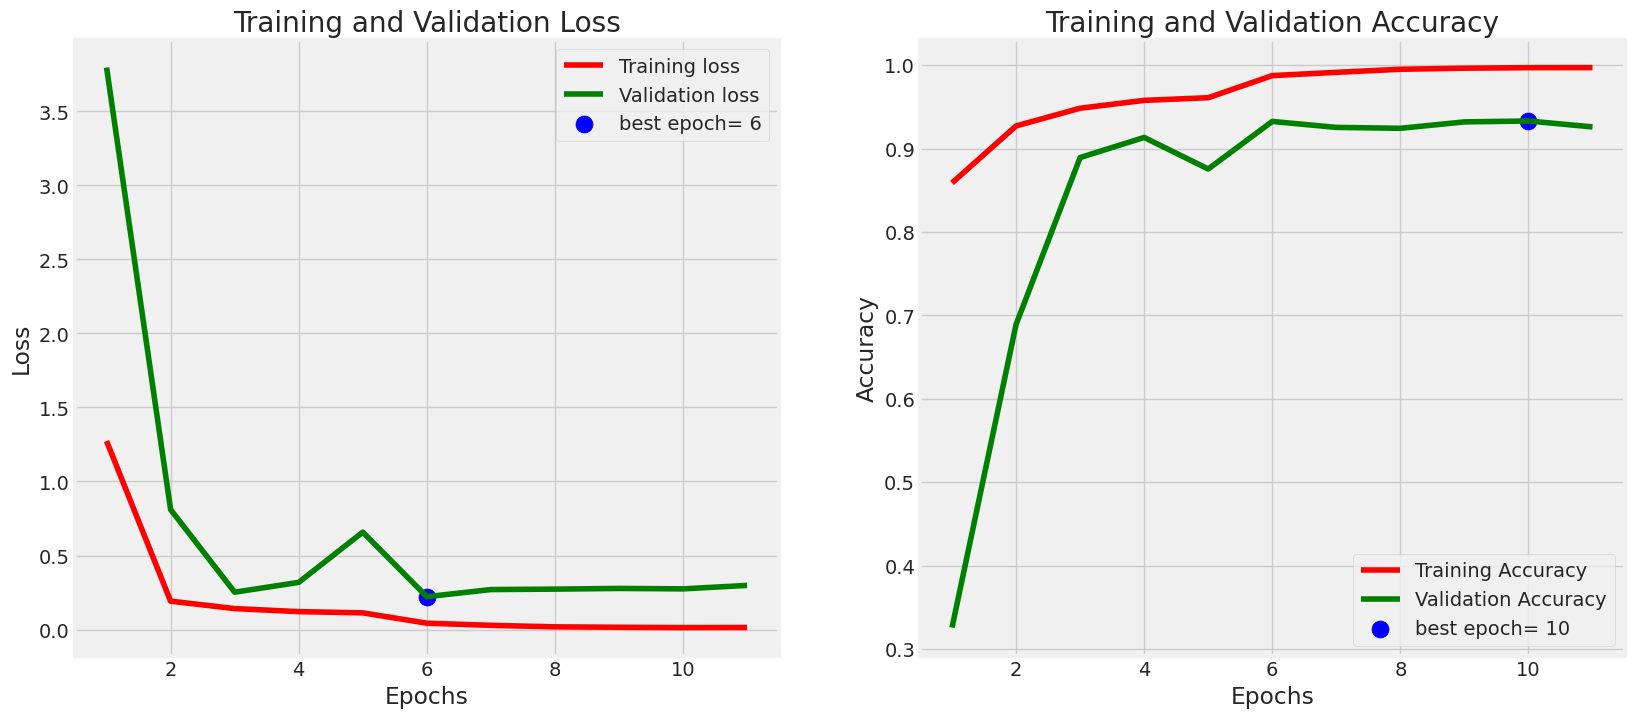

In [31]:
plot_training(history)

In [32]:
test_gen.samples

2250

In [36]:
ts_length = 2250
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model_lung.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model_lung.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model_lung.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

30/30 [==============================] - 6s 198ms/step - loss: 0.2535 - accuracy: 0.9062
Train Loss:  0.020976265892386436
Train Accuracy:  0.996874988079071
--------------------
Validation Loss:  0.20291905105113983
Validation Accuracy:  0.9322916865348816
--------------------
Test Loss:  0.25346583127975464
Test Accuracy:  0.90625


In [37]:
test_loss, test_accuracy = model_lung.evaluate(
    test_gen,
    steps=test_gen.samples // test_gen.batch_size
)

print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

70/70 [==============================] - 14s 198ms/step - loss: 0.2074 - accuracy: 0.9308
Test loss: 0.2074330449104309, Test accuracy: 0.9308035969734192


In [38]:


model = load_model("model_lung.h5")

test_loss, test_accuracy = model_lung.evaluate(test_gen, steps=test_gen.samples // test_gen.batch_size)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')


70/70 [==============================] - 14s 198ms/step - loss: 0.2074 - accuracy: 0.9308
Test loss: 0.2074330449104309, Test accuracy: 0.9308035969734192


In [39]:
predictions = model_lung.predict(test_gen, steps=test_gen.samples // test_gen.batch_size)
predicted_class_indices = np.argmax(predictions, axis=-1)  
if test_gen.class_indices:
    labels = (test_gen.class_indices)
    labels = dict((v, k) for k, v in labels.items())  
    predictions_labels = [labels[k] for k in predicted_class_indices]
for i in range(10):  
    actual_label = test_gen.filenames[i].split('/')[0]
    predicted_label = predictions_labels[i]
    print(f'Actual label: {actual_label}, Predicted label: {predicted_label}')

70/70 [==============================] - 14s 194ms/step
Actual label: lung_aca, Predicted label: lung_aca
Actual label: lung_aca, Predicted label: lung_aca
Actual label: lung_aca, Predicted label: lung_aca
Actual label: lung_aca, Predicted label: lung_aca
Actual label: lung_aca, Predicted label: lung_aca
Actual label: lung_aca, Predicted label: lung_aca
Actual label: lung_aca, Predicted label: lung_aca
Actual label: lung_aca, Predicted label: lung_aca
Actual label: lung_aca, Predicted label: lung_aca
Actual label: lung_aca, Predicted label: lung_aca


[0 0 0 ... 2 2 2]
Confusion Matrix, Without Normalization
[[662   2  86]
 [  5 745   0]
 [ 62   0 688]]
              precision    recall  f1-score   support

    lung_aca       0.91      0.88      0.90       750
      lung_n       1.00      0.99      1.00       750
    lung_scc       0.89      0.92      0.90       750

    accuracy                           0.93      2250
   macro avg       0.93      0.93      0.93      2250
weighted avg       0.93      0.93      0.93      2250



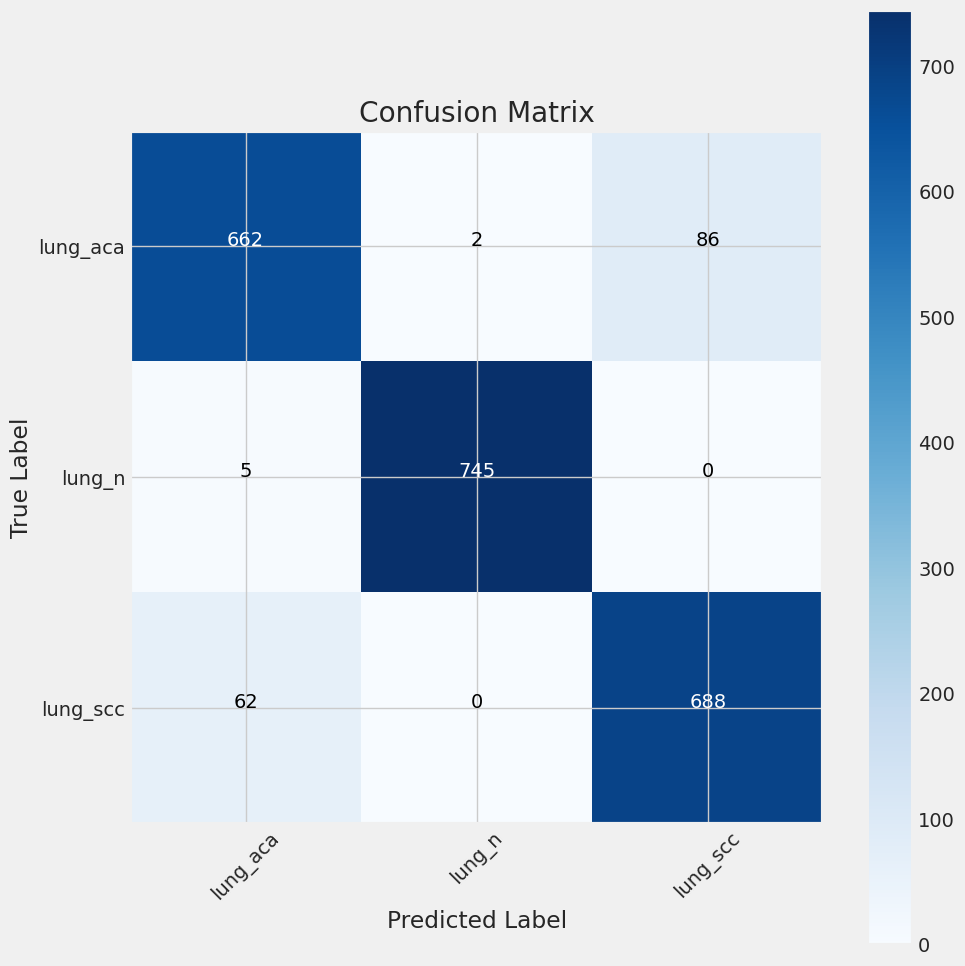

In [40]:
preds = model_lung.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

print(classification_report(test_gen.classes, y_pred, target_names= classes))

In [41]:


model = load_model("/kaggle/working/model_lung.h5")

def predict_image_class(img_path, model, image_size=(224, 224)):
    img = image.load_img(img_path, target_size=image_size)
    
    img_array = image.img_to_array(img)
    
    img_array = img_array / 255.0
    
    img_array = np.expand_dims(img_array, axis=0)
    
    predictions = model.predict(img_array)
    
    predicted_class_index = np.argmax(predictions, axis=-1)
    
    label_map = (train_gen.class_indices)  
    label_map = dict((v, k) for k, v in label_map.items()) 
    
    predicted_class_label = label_map[predicted_class_index[0]]
    
    return predicted_class_label

new_image_path = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_n/lungn10.jpeg'

predicted_class = predict_image_class(new_image_path, model)
print(f'The image belongs to class: {predicted_class}')


1/1 [==============================] - 1s 1s/step
The image belongs to class: lung_n


In [42]:


model_path = 'model_lung.h5'
model = load_model(model_path)

test_dir = os.path.join(base_dir, 'test')

def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array /= 255.0 
    return img_array

class_names = os.listdir(test_dir)

results = []

for _ in range(10):
    random_class_name = random.choice(class_names)

    image_files = os.listdir(os.path.join(test_dir, random_class_name))

    random_image_file = random.choice(image_files)

    random_image_path = os.path.join(test_dir, random_class_name, random_image_file)

    img_array = preprocess_image(random_image_path)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction, axis=1)

    class_indices = {'lung_aca': 0, 'lung_n': 1, 'lung_scc': 2}

    predicted_class_name = list(class_indices.keys())[list(class_indices.values()).index(predicted_class_index[0])]

    results.append((random_image_path, random_class_name, predicted_class_name))

for img_path, actual, predicted in results:
    print(f"Selected image path: {img_path}")
    print(f"Actual class: {actual}")
    print(f"Predicted class: {predicted}")
    print('---')


1/1 [==============================] - 0s 22ms/step
Selected image path: split_lung_images/test/lung_scc/lungscc2289.jpeg
Actual class: lung_scc
Predicted class: lung_scc
---
Selected image path: split_lung_images/test/lung_n/lungn4438.jpeg
Actual class: lung_n
Predicted class: lung_n
---
Selected image path: split_lung_images/test/lung_scc/lungscc4770.jpeg
Actual class: lung_scc
Predicted class: lung_scc
---
Selected image path: split_lung_images/test/lung_aca/lungaca3594.jpeg
Actual class: lung_aca
Predicted class: lung_aca
---
Selected image path: split_lung_images/test/lung_scc/lungscc4206.jpeg
Actual class: lung_scc
Predicted class: lung_scc
---
Selected image path: split_lung_images/test/lung_aca/lungaca2163.jpeg
Actual class: lung_aca
Predicted class: lung_aca
---
Selected image path: split_lung_images/test/lung_n/lungn1735.jpeg
Actual class: lung_n
Predicted class: lung_n
---
Selected image path: split_lung_images/test/lung_scc/lungscc4641.jpeg
Actual class: lung_scc
Predicted 